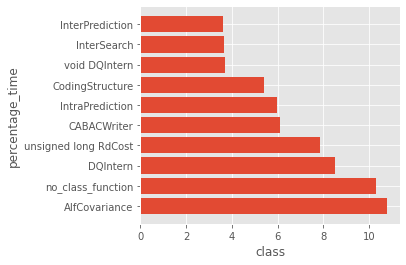

In [64]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

file_path = 'akiyo.txt'

class gprof_data_analyser: 

    def __init_data_frame__(self):
        columns_name = (
            'percentage_time',
            'cumulative_sec',
            'self_sec',
            'calls',
            'self sec/call',
            'total sec/call',
            'name'
        )

        #initialize data_frame with the parameters analysed in GNU Profiler
        self.data_frame = {}
        for column in columns_name:
            self.data_frame[column] = []

    def read_gprof(self, file_path: str):

        # saves the input file name without the extension
        self.file_input = os.path.splitext(file_path)[0]

        self.__init_data_frame__()

        ptrn = re.compile(r'^\s*(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d*)\s+(\d+\.\d+)*\s+(\d+\.\d+)*\s+(.+)\s*$')
        
        with open(file_path) as file:
            for line in file:
                check = ptrn.findall(line)
                # check = (['p1', 'p2', 'p3', ..., 'pn']), therefore check has a
                # tuple with a list of each parameter analysed by GProf

                # if found a line with data
                if len(check) > 0:
                    # eliminates the tuple
                    check = check[0]
                    for i, column in enumerate(self.data_frame.keys()):
                        try:
                            # verify if its numeric
                            self.data_frame[column].append(float(check[i]))
                        except:
                            if check[i] == '':
                                self.data_frame[column].append(0)
                            else:
                                # appends the string without cast
                                self.data_frame[column].append(check[i])
            file.close()

        # create new parameters to separate class and function of any name
        self.data_frame['class'] = []
        self.data_frame['function'] = []

        ptrn_name = re.compile(r'(?:^([^:]+)(?:::)([^\(]+).+$)|(?:^(([^\(<]+)))')

        for name in self.data_frame['name']:
            check = ptrn_name.findall(name)
            if len(check) > 0:
                # verify if the function has a class or not
                if (check[0][0] != ''):
                    self.data_frame['class'].append(check[0][0])
                    self.data_frame['function'].append(check[0][1])
                else:
                    self.data_frame['class'].append('no_class_function')
                    self.data_frame['function'].append(check[0][2])

        # converts the dict into a data frame
        self.data_frame = pd.DataFrame(self.data_frame)
        # creates a data frame in which the parameters are grouped by each class
        self.data_frame_by_class = pd.pivot_table(
            self.data_frame, 
            index='class', 
            values=[
                'percentage_time',
                'cumulative_sec',
                'self_sec',
                'calls',
                'self sec/call',
                'total sec/call'
            ], 
            aggfunc='sum'
        )

    def to_csv(self, output_name=None):
        try:
            if output_name == None:
                self.data_frame.to_csv(self.file_input+'.csv', index=False)
            else:
                self.data_frame.to_csv(os.path.splitext(output_name)[0]+'csv')
        except:
            raise Exception('unknown error has occurred')

    def to_excel(self, output_name=None):
        try:
            if output_name == None:
                self.data_frame.to_excel(self.file_input+'.xlsx')
            else:
                self.data_frame.to_excel(os.path.splitext(output_name)[0]+'xlsx')
        except:
            raise Exception('unknown error has occurred')

    def plot_data(
        self, 
        x='class', 
        y='percentage_time', 
        quant=10, 
        savefig=False, 
        output_name='plot.jpg'):

        try: 
            df = self.data_frame_by_class.reset_index().sort_values(by='percentage_time', ascending=False)
            df = df.head(quant)
            
            plt.subplots_adjust(left=0.3)
            plt.xlabel(x) 
            plt.ylabel(y)

            plt.barh(df[x], df[y])

            if savefig:
                plt.savefig(output_name)
        except:
            raise Exception('Unknown error has occurred')
    
data_handle = gprof_data_analyser()
data_handle.read_gprof(file_path)
data_handle.plot_data(savefig=True)
data_handle.to_excel()
data_handle.to_csv()